In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# importing necessary libraries
import os
import copy
# library to work with arrays
import numpy as np
# library to work with dataframes
import pandas as pd
# libraries to work with images
import cv2 
import PIL
from PIL import Image
#libraries for data visualisation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns
from matplotlib import pyplot as plt

# THIS NOTEBOOK USES torch implementation 
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
# new metric
from sklearn.metrics import roc_auc_score

In [32]:
# introdcoduce the transform for train and validation datasets
# Image -> Tensor Image -> Normalized image
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

data_dir = "../input/alzheimer-s-dataset/Alzheimer_s Dataset"

test_data = datasets.ImageFolder(data_dir + '/test', 
                                 transform=transforms)

train_data = {x: datasets.ImageFolder(os.path.join(data_dir + "/train", x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

trainloader = {x: torch.utils.data.DataLoader(train_data[x], batch_size=32,
                                             shuffle=True
                                              )
              for x in ['train', 'val']}

testloader = torch.utils.data.DataLoader(test_data, 
                                         shuffle=True, 
                                         batch_size=32)

In [33]:
import time
import torch.nn.functional as F
# function to train models
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, is_inception=False):
    
    since = time.time()
    # arrays to store accuracy, AUC, and losses for each epoch so that can be plotted later on
    val_acc_history = []
    train_acc_history = []

    val_auc_history = []
    train_auc_history = []

    epoch_losses = []
    epoch_accuracies = []

    val_loss_history = []
    train_loss_history = []
    # time decay learning rate
    
    # use either time decay or step lr based on configs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
#     lambda1 = lambda epoch: 1/(1 + 0.05 ** epoch) 
#     scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    best_acc = 0.0
    # for training we need GPU (cuda)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # this variable is activated if epoch > 30 and model does not improve on performance
    early_stop = False
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            y_predict = []
            y_label = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
            
                y_predict += [tensor.item() for tensor in preds]
                y_label += [tensor.item() for tensor in labels.data]

            # calculate auc score for an epoch
            label_class=[0, 1, 2, 3]
            y_pred_b = label_binarize(y_predict, classes=label_class)
            y_label_b = label_binarize(y_label, classes=label_class)
            roc_auc = roc_auc_score(y_label_b, y_pred_b, multi_class='ovr')

            # update scheduler only on epoch stages
            if phase=="train":
              scheduler.step()
            # calculate loss for train/val
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f} Roc_auc: {:.4f} LR: {}'.format(phase, epoch_loss, epoch_acc, roc_auc, optimizer.param_groups[0]['lr']))
            # add the loss/acc/auc to val or train history sets
            if phase == 'val':
                  val_loss_history.append(epoch_loss)
                  val_acc_history.append(epoch_acc)
                  val_auc_history.append(roc_auc)
            if phase == 'train':
                  train_loss_history.append(epoch_loss)
                  train_acc_history.append(epoch_acc)
                  train_auc_history.append(roc_auc)
            # deep copy the model
            if phase == 'val':
                print("val")
                # if model has improved -> set new best model
                if epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
                  epochs_no_improve = 0
                # if not, then start counting number of epochs w/o improvement
                if epoch_acc <= best_acc:
                    epochs_no_improve += 1
                    print(epochs_no_improve)
                # if num of epochs is >= 15 and no improvement over 10 epochs -> early stopping
                if epoch >= 15 and epochs_no_improve > 10:
                    print('Early stopping!')
                    early_stop = True
                    break
        # stop the model
        if early_stop==True:
          break          

        print()
    # statistical output of execution time
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)

    # return best model and train/val history
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, train_auc_history, val_auc_history

In [34]:
def plot_mispredicted(images, opt_folder, model_name):
  plt.figure(figsize=(16, 12))
  for i, image in enumerate(images):
    plt.subplot(len(images)//5 + 1,5, i+1)
    (images[i][0].to('cpu').permute(1, 2, 0)[:,:,0]).save(data_dir + f'{opt_folder}/' + f'{model_name}/' + f"{i}__{images[i][2]}_pred as_{images[i][1]}.png", 'PNG')
    plt.title(f"{images[i][2]} pred as {images[i][1]}")
    plt.axis('off')

In [35]:
class ConvNeuralNet3(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torch.nn.Sequential(
            #Input = 3 x 32 x 32, Output = 32 x 32 x 32
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), 
            torch.nn.ReLU(),
            #Input = 32 x 32 x 32, Output = 32 x 16 x 16
            torch.nn.MaxPool2d(kernel_size=2),
  
            #Input = 32 x 16 x 16, Output = 64 x 16 x 16
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            #Input = 64 x 16 x 16, Output = 64 x 8 x 8
            torch.nn.MaxPool2d(kernel_size=2),
              
            #Input = 64 x 8 x 8, Output = 64 x 8 x 8
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            #Input = 64 x 8 x 8, Output = 64 x 4 x 4
            torch.nn.MaxPool2d(kernel_size=2),
  
            torch.nn.Flatten(),
            torch.nn.Linear(9152, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )
  
    def forward(self, x):
        return self.model(x)

In [19]:
class ConvNeuralNet5(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet5, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)

        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        self.fc1 = nn.Linear(5120, 500)
        self.fc2 = nn.Linear(500, num_classes)

        self.softmax = nn.Softmax(dim=1)
        self.relu = ReLU()
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.dropout1d = nn.Dropout(p=0.25)
        #self.dropout2d = nn.Dropout(p=0.4)
  
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu(out)
        out = self.conv_layer2(out)
        out = self.relu(out)
        out = self.max_pool1(out)
        out = self.batchnorm32(out)

        out = self.conv_layer3(out)
        out = self.relu(out)
        out = self.conv_layer4(out)
        out = self.relu(out)
        out = self.max_pool2(out)
        out = self.batchnorm64(out)
        
        out = self.conv_layer5(out)
        out = self.relu(out)
        out = self.max_pool2(out)
        out = self.dropout1d(out)  

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout1d(out)

        out = self.fc2(out) 
        #out = self.softmax(out) 

        return out

In [42]:
# function provided by torch API to create various models (not pretrained)
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    def add_network(num_ftrs):
        added_network = nn.Sequential(
        nn.Linear(num_ftrs, num_ftrs//8),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(num_ftrs//8, num_ftrs//64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(num_ftrs//64, num_classes),
        )
        return added_network
    
    model_ft = None
    input_size = 0
    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = add_network(num_ftrs)
        # input size can be modified (here is the image aspect)
        input_size = 224
    
    elif model_name == "efficientnet":

        model_ft = models.efficientnet_b7(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = add_network(num_ftrs)
        input_size = 224
        
    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = add_network(num_ftrs)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = add_network(num_ftrs)
        input_size = 224

    elif model_name == "mobilenet":
        model_ft = models.mobilenet_v2(pretrained=True)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = add_network(num_ftrs)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [48]:
#Selecting the appropriate training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Defining the model hyper parameters
epochs = 30
num_classes = 4
learning_rate = 0.0001
weight_decay = 0.01


weights = torch.tensor([717, 52, 2560, 1792], dtype=torch.float32)

# calculate weights
weights = weights / weights.sum()
weights = 1.0 / weights
weights = weights / weights.sum()
weights = weights.to(device)

# specify weighed loss with or without weighted loss
criterion = torch.nn.CrossEntropyLoss(weight=weights)

In [44]:
# 1000 is a fill-in parameter,not used by the models
densenet, input = initialize_model('densenet', num_classes, 1000, use_pretrained=True)
densenet = densenet.to(device)

efficientnet, input = initialize_model('efficientnet', num_classes, 1000, use_pretrained=True)
efficientnet = efficientnet.to(device)

mobilenet, input = initialize_model('mobilenet', num_classes, 1000, use_pretrained=True)
mobilenet = mobilenet.to(device)

# specify weighed loss with or without weighted loss
#criterion = torch.nn.CrossEntropyLoss()

# create an adam optimizer for each model (learning rates are copied from the papaer configuration)
optimizer_densenet = torch.optim.Adam(densenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_efficientnet = torch.optim.Adam(efficientnet.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_mobilenet = torch.optim.Adam(mobilenet.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [23]:
model_e_adam, train_acc_history_e, val_acc_history_e, train_loss_history_e, val_loss_history_e, train_auc_history_e, val_auc_history_e = train_model(efficientnet, trainloader, criterion, optimizer_efficientnet, epochs)
torch.cuda.empty_cache()

Epoch 0/29
----------
train Loss: 0.1274 Acc: 0.5079 Roc_auc: 0.5683 LR: 0.0001
val Loss: 0.1625 Acc: 0.3502 Roc_auc: 0.5000 LR: 0.0001
val
1

Epoch 1/29
----------
train Loss: 0.1014 Acc: 0.6457 Roc_auc: 0.6420 LR: 0.0001
val Loss: 0.1648 Acc: 0.3502 Roc_auc: 0.5000 LR: 0.0001
val
2

Epoch 2/29
----------
train Loss: 0.0840 Acc: 0.7178 Roc_auc: 0.7014 LR: 0.0001
val Loss: 0.1343 Acc: 0.4047 Roc_auc: 0.5309 LR: 0.0001
val
1

Epoch 3/29
----------
train Loss: 0.0668 Acc: 0.7957 Roc_auc: 0.7480 LR: 0.0001
val Loss: 0.2148 Acc: 0.3979 Roc_auc: 0.5678 LR: 0.0001
val
2

Epoch 4/29
----------
train Loss: 0.0481 Acc: 0.8578 Roc_auc: 0.7891 LR: 0.0001
val Loss: 0.1634 Acc: 0.4484 Roc_auc: 0.5682 LR: 0.0001
val
1

Epoch 5/29
----------
train Loss: 0.0356 Acc: 0.8993 Roc_auc: 0.8168 LR: 0.0001
val Loss: 0.1866 Acc: 0.4358 Roc_auc: 0.5947 LR: 0.0001
val
2

Epoch 6/29
----------
train Loss: 0.0296 Acc: 0.9172 Roc_auc: 0.8276 LR: 1e-05
val Loss: 0.1223 Acc: 0.6187 Roc_auc: 0.6445 LR: 1e-05
val
1

E

In [39]:
model_m_adam, train_acc_history_m, val_acc_history_m, train_loss_history_m, val_loss_history_m, train_auc_history_m, val_auc_history_m = train_model(mobilenet, trainloader, criterion, optimizer_mobilenet, epochs)
torch.cuda.empty_cache()

Epoch 0/29
----------
train Loss: 0.0365 Acc: 0.5148 Roc_auc: 0.6126 LR: 0.0001
val Loss: 0.0305 Acc: 0.6479 Roc_auc: 0.6983 LR: 0.0001
val
1

Epoch 1/29
----------
train Loss: 0.0205 Acc: 0.7088 Roc_auc: 0.8209 LR: 0.0001
val Loss: 0.0280 Acc: 0.6955 Roc_auc: 0.7529 LR: 0.0001
val
1

Epoch 2/29
----------
train Loss: 0.0085 Acc: 0.8954 Roc_auc: 0.9392 LR: 0.0001
val Loss: 0.0268 Acc: 0.6848 Roc_auc: 0.7457 LR: 0.0001
val
2

Epoch 3/29
----------
train Loss: 0.0049 Acc: 0.9428 Roc_auc: 0.9693 LR: 0.0001
val Loss: 0.0259 Acc: 0.7636 Roc_auc: 0.7759 LR: 0.0001
val
1

Epoch 4/29
----------
train Loss: 0.0026 Acc: 0.9739 Roc_auc: 0.9853 LR: 0.0001
val Loss: 0.0389 Acc: 0.7335 Roc_auc: 0.7388 LR: 0.0001
val
2

Epoch 5/29
----------
train Loss: 0.0027 Acc: 0.9707 Roc_auc: 0.9780 LR: 0.0001
val Loss: 0.0462 Acc: 0.7247 Roc_auc: 0.7207 LR: 0.0001
val
3

Epoch 6/29
----------
train Loss: 0.0033 Acc: 0.9626 Roc_auc: 0.9800 LR: 1e-05
val Loss: 0.0288 Acc: 0.7510 Roc_auc: 0.7900 LR: 1e-05
val
4

E

In [45]:
model_d_adam, train_acc_history_d, val_acc_history_d, train_loss_history_d, val_loss_history_d, train_auc_history_d, val_auc_history_d = train_model(densenet, trainloader, criterion, optimizer_densenet, epochs)
torch.cuda.empty_cache()

Epoch 0/29
----------
train Loss: 0.0369 Acc: 0.5395 Roc_auc: 0.6139 LR: 0.0001
val Loss: 0.0358 Acc: 0.5671 Roc_auc: 0.6018 LR: 0.0001
val
1

Epoch 1/29
----------
train Loss: 0.0249 Acc: 0.6817 Roc_auc: 0.7862 LR: 0.0001
val Loss: 0.0258 Acc: 0.6955 Roc_auc: 0.7993 LR: 0.0001
val
1

Epoch 2/29
----------
train Loss: 0.0125 Acc: 0.8573 Roc_auc: 0.9212 LR: 0.0001
val Loss: 0.0366 Acc: 0.6780 Roc_auc: 0.6717 LR: 0.0001
val
2

Epoch 3/29
----------
train Loss: 0.0097 Acc: 0.9040 Roc_auc: 0.9329 LR: 0.0001
val Loss: 0.0303 Acc: 0.7189 Roc_auc: 0.7411 LR: 0.0001
val
1

Epoch 4/29
----------
train Loss: 0.0058 Acc: 0.9484 Roc_auc: 0.9623 LR: 0.0001
val Loss: 0.0240 Acc: 0.7053 Roc_auc: 0.8208 LR: 0.0001
val
2

Epoch 5/29
----------
train Loss: 0.0034 Acc: 0.9665 Roc_auc: 0.9754 LR: 0.0001
val Loss: 0.0283 Acc: 0.7228 Roc_auc: 0.7663 LR: 0.0001
val
1

Epoch 6/29
----------
train Loss: 0.0031 Acc: 0.9743 Roc_auc: 0.9786 LR: 1e-05
val Loss: 0.0675 Acc: 0.5720 Roc_auc: 0.6618 LR: 1e-05
val
2

E

In [ ]:
# model_v_adam, train_acc_history_v, val_acc_history_v, train_loss_history_v, val_loss_history_v, train_auc_history_v, val_auc_history_v = train_model(vgg, trainloader, criterion, optimizer_vgg, epochs)
# torch.cuda.empty_cache()

In [ ]:
# model_r_adam, train_acc_history_r, val_acc_history_r, train_loss_history_r, val_loss_history_r, train_auc_history_r, val_auc_history_r = train_model(resnet, trainloader, criterion, optimizer_resnet, epochs)
# torch.cuda.empty_cache()

In [70]:
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def display_results(models):
    # evaluate the models 
    test_acc=0
    f, axs = plt.subplots(1,5,figsize=(20,4))
    j=0
    d = defaultdict(list)
    for model in models:
      model.eval()
      y_label = []
      y_predict = []  
      with torch.no_grad():
          #Iterating over the training dataset in batches
          for i, (images, labels) in enumerate(testloader):

              images = images.to(device)
              y_true = labels.to(device)

              #Calculating outputs for the batch being iterated
              outputs = model(images)
             #roc_auc_score([tensor.item() for tensor in labels.data], probabilities, multi_class='ovr')           
              #Calculated prediction labels from models
              _, y_pred = torch.max(outputs.data, 1)
              #Comparing predicted and true labels
              test_acc += (y_pred == y_true).sum().item()
              for i in range(len(y_pred)):
                if y_pred[i] != y_true[i]:
                  d[j].append((images[i], y_pred[i], y_true[i]))
              y_predict += [tensor.item() for tensor in y_pred]
              y_label += [tensor.item() for tensor in labels.data]

          label_class=[0, 1, 2, 3]
          y_pred_b = label_binarize(y_predict, classes=label_class)
          y_label_b = label_binarize(y_label, classes=label_class)
          test_auc = roc_auc_score(y_label_b, y_pred_b, multi_class="ovr")
          print(f"Test set accuracy = {np.round(100 * test_acc / len(test_data),decimals=2)} %")
          print(f"Test set AUC = {np.round(test_auc, decimals=3)}")
          # plot the confusion matrix
          cm = confusion_matrix(y_label, y_predict)
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          disp = ConfusionMatrixDisplay(cm,
                                      display_labels=['Mild', 'Moderate', 'Non', 'VeryMild'])
                                      
          disp.plot(ax=axs[j], xticks_rotation=45)
          disp.ax_.set_title(model.__class__.__name__)
          disp.im_.colorbar.remove()
          disp.ax_.set_xlabel('')
          if j!=0:
              disp.ax_.set_ylabel('')
          j+=1
      test_acc = 0
    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    f.colorbar(disp.im_, ax=axs)
    plt.show()

In [51]:
#display_results([model3_adam, model5_adam,model_d_adam,model_v_adam,model_r_adam])

Test set accuracy = 76.0 %
Test set AUC = 0.808


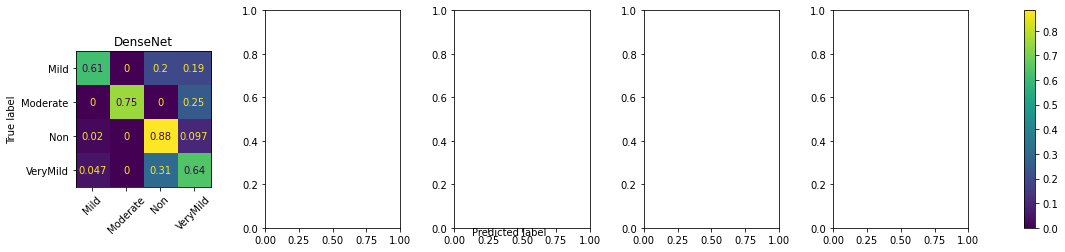

In [46]:
display_results([model_d_adam])

In [28]:
cnn3 = ConvNeuralNet3(num_classes).to(device)
cnn5 = ConvNeuralNet5(num_classes).to(device)
# 1000 is a fill-in parameter,not used by the models
densenet, input = initialize_model('densenet', num_classes, 1000, use_pretrained=True)
densenet = densenet.to(device)

vgg, input = initialize_model('vgg', num_classes, 1000, use_pretrained=True)
vgg = vgg.to(device)

resnet, input = initialize_model('resnet', num_classes, 1000, use_pretrained=True)
resnet = resnet.to(device)

# specify weighed loss with or without weighted loss
#criterion = torch.nn.CrossEntropyLoss()
optimizer3 = torch.optim.RMSprop(cnn3.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer5 = torch.optim.RMSprop(cnn5.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_densenet = torch.optim.RMSprop(densenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_vgg = torch.optim.RMSprop(vgg.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_resnet = torch.optim.RMSprop(resnet.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
# model3_rms, train_acc_history3, val_acc_history3, train_loss_history3, val_loss_history3, train_auc_history_3, val_auc_history_3 = train_model(cnn3, trainloader, criterion, optimizer3, epochs)
# torch.cuda.empty_cache()


In [ ]:
# model5_rms, train_acc_history5, val_acc_history5, train_loss_history5, val_loss_history5, train_auc_history_5, val_auc_history_5 = train_model(cnn5, trainloader, criterion, optimizer5, epochs)
# torch.cuda.empty_cache()

In [29]:
model_d_rms, train_acc_history_d, val_acc_history_d, train_loss_history_d, val_loss_history_d, train_auc_history_d, val_auc_history_d = train_model(densenet, trainloader, criterion, optimizer_densenet, epochs)
torch.cuda.empty_cache()


Epoch 0/29
----------
train Loss: 0.0265 Acc: 0.6240 Roc_auc: 0.6307 LR: 0.0001
val Loss: 0.0250 Acc: 0.6868 Roc_auc: 0.6503 LR: 0.0001
val
1

Epoch 1/29
----------
train Loss: 0.0124 Acc: 0.8686 Roc_auc: 0.7991 LR: 0.0001
val Loss: 0.0375 Acc: 0.6576 Roc_auc: 0.6379 LR: 0.0001
val
2

Epoch 2/29
----------
train Loss: 0.0070 Acc: 0.9384 Roc_auc: 0.8400 LR: 0.0001
val Loss: 0.0392 Acc: 0.6391 Roc_auc: 0.6308 LR: 0.0001
val
3

Epoch 3/29
----------
train Loss: 0.0046 Acc: 0.9614 Roc_auc: 0.8548 LR: 0.0001
val Loss: 0.0717 Acc: 0.5866 Roc_auc: 0.5577 LR: 0.0001
val
4

Epoch 4/29
----------
train Loss: 0.0041 Acc: 0.9624 Roc_auc: 0.8550 LR: 0.0001
val Loss: 0.0436 Acc: 0.6605 Roc_auc: 0.6358 LR: 0.0001
val
5

Epoch 5/29
----------
train Loss: 0.0036 Acc: 0.9643 Roc_auc: 0.8557 LR: 0.0001
val Loss: 0.0317 Acc: 0.7179 Roc_auc: 0.6778 LR: 0.0001
val
1

Epoch 6/29
----------
train Loss: 0.0027 Acc: 0.9746 Roc_auc: 0.8722 LR: 1e-05
val Loss: 0.0290 Acc: 0.7247 Roc_auc: 0.6988 LR: 1e-05
val
1

E

In [19]:
# model_v_rms, train_acc_history_v, val_acc_history_v, train_loss_history_v, val_loss_history_v, train_auc_history_v, val_auc_history_v = train_model(vgg, trainloader, criterion, optimizer_vgg, epochs)
# torch.cuda.empty_cache()


In [21]:
# model_r_rms, train_acc_history_r, val_acc_history_r, train_loss_history_r, val_loss_history_r, train_auc_history_r, val_auc_history_r = train_model(resnet, trainloader, criterion, optimizer_resnet, epochs)
# torch.cuda.empty_cache()

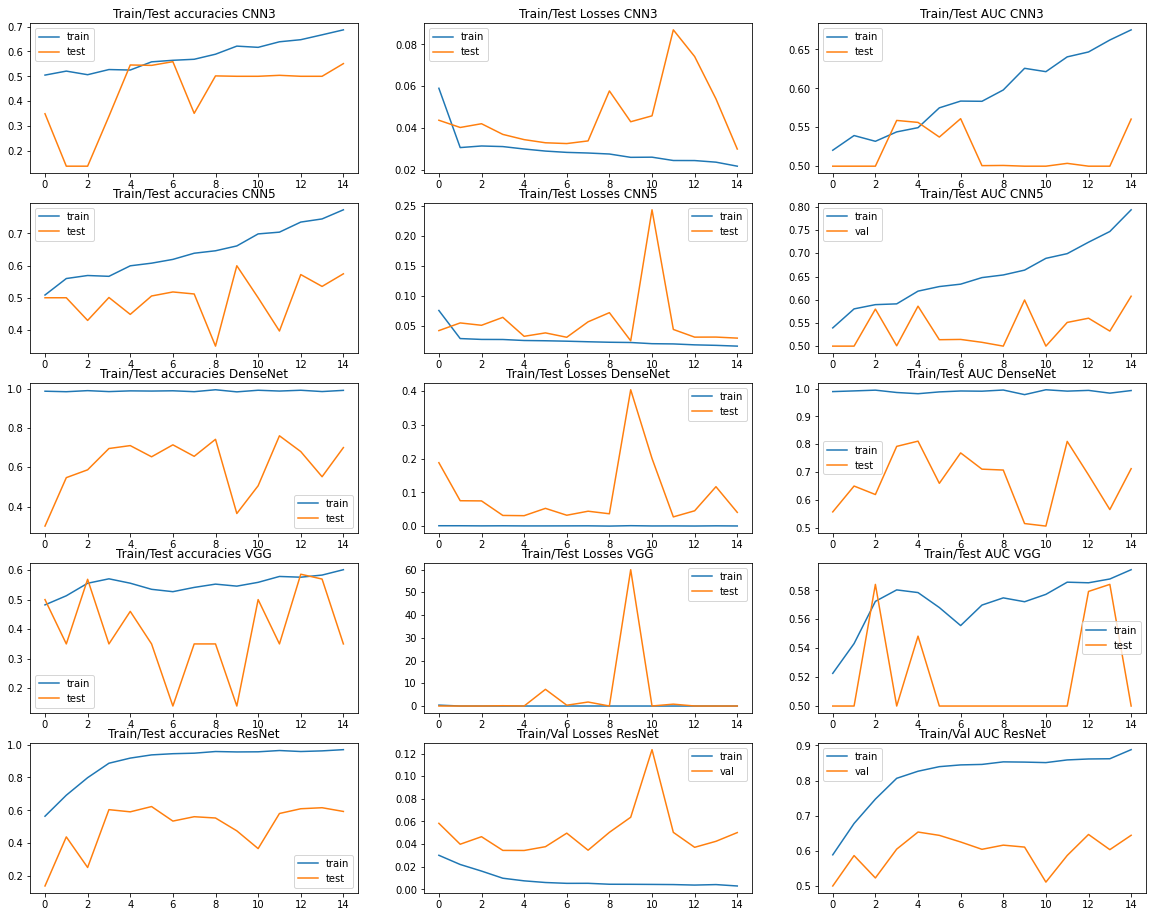

In [51]:
f, axs = plt.subplots(5,3,figsize=(20,16))
axs[0,0].plot([tensor.item() for tensor in train_acc_history3], label="train")
axs[0,0].plot([tensor.item() for tensor in val_acc_history3], label="test")
axs[0,0].set_title("Train/Test accuracies CNN3")
axs[0,0].legend()
axs[0,1].plot(train_loss_history3, label="train")
axs[0,1].plot(val_loss_history3, label="test")
axs[0,1].set_title("Train/Test Losses CNN3")
axs[0,1].legend()
axs[0,2].plot(train_auc_history_3, label="train")
axs[0,2].plot(val_auc_history_3, label="test")
axs[0,2].set_title("Train/Test AUC CNN3")
axs[0,2].legend()

axs[1,0].plot([tensor.item() for tensor in train_acc_history5], label="train")
axs[1,0].plot([tensor.item() for tensor in val_acc_history5], label="test")
axs[1,0].set_title("Train/Test accuracies CNN5")
axs[1,0].legend()
axs[1,1].plot(train_loss_history5, label="train")
axs[1,1].plot(val_loss_history5, label="test")
axs[1,1].set_title("Train/Test Losses CNN5")
axs[1,1].legend()
axs[1,2].plot(train_auc_history_5, label="train")
axs[1,2].plot(val_auc_history_5, label="val")
axs[1,2].set_title("Train/Test AUC CNN5")
axs[1,2].legend()

axs[2,0].plot([tensor.item() for tensor in train_acc_history_d], label="train")
axs[2,0].plot([tensor.item() for tensor in val_acc_history_d], label="test")
axs[2,0].set_title("Train/Test accuracies DenseNet")
axs[2,0].legend()
axs[2,1].plot(train_loss_history_d, label="train")
axs[2,1].plot(val_loss_history_d, label="test")
axs[2,1].set_title("Train/Test Losses DenseNet")
axs[2,1].legend()
axs[2,2].plot(train_auc_history_d, label="train")
axs[2,2].plot(val_auc_history_d, label="test")
axs[2,2].set_title("Train/Test AUC DenseNet")
axs[2,2].legend()

axs[3,0].plot([tensor.item() for tensor in train_acc_history_v], label="train")
axs[3,0].plot([tensor.item() for tensor in val_acc_history_v], label="test")
axs[3,0].set_title("Train/Test accuracies VGG")
axs[3,0].legend()
axs[3,1].plot(train_loss_history_v, label="train")
axs[3,1].plot(val_loss_history_v, label="test")
axs[3,1].set_title("Train/Test Losses VGG")
axs[3,1].legend()
axs[3,2].plot(train_auc_history_v, label="train")
axs[3,2].plot(val_auc_history_v, label="test")
axs[3,2].set_title("Train/Test AUC VGG")
axs[3,2].legend()

axs[4,0].plot([tensor.item() for tensor in train_acc_history_r], label="train")
axs[4,0].plot([tensor.item() for tensor in val_acc_history_r], label="test")
axs[4,0].set_title("Train/Test accuracies ResNet")
axs[4,0].legend()
axs[4,1].plot(train_loss_history_r, label="train")
axs[4,1].plot(val_loss_history_r, label="val")
axs[4,1].set_title("Train/Val Losses ResNet")
axs[4,1].legend()
axs[4,2].plot(train_auc_history_r, label="train")
axs[4,2].plot(val_auc_history_r, label="val")
axs[4,2].set_title("Train/Val AUC ResNet")
axs[4,2].legend()

In [52]:
#display_results([model3_rms, model5_rms,model_d_rms,model_v_rms,model_r_rms])

Test set accuracy = 78.5 %
Test set AUC = 0.826


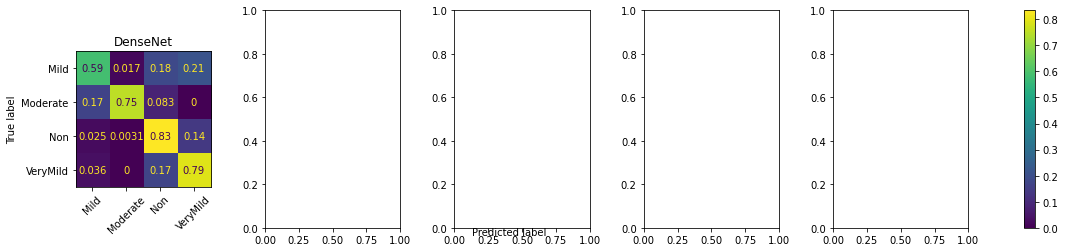

In [37]:
display_results([model_d_rms])

In [49]:
cnn3 = ConvNeuralNet3(num_classes).to(device)
cnn5 = ConvNeuralNet5(num_classes).to(device)
# 1000 is a fill-in parameter,not used by the models
densenet, input = initialize_model('densenet', num_classes, 1000, use_pretrained=True)
densenet = densenet.to(device)

vgg, input = initialize_model('vgg', num_classes, 1000, use_pretrained=True)
vgg = vgg.to(device)

resnet, input = initialize_model('resnet', num_classes, 1000, use_pretrained=True)
resnet = resnet.to(device)

# specify weighed loss with or without weighted loss
#criterion = torch.nn.CrossEntropyLoss()
optimizer3 = torch.optim.SGD(cnn3.parameters(), lr=learning_rate,momentum=0.9, weight_decay=weight_decay)
optimizer5 = torch.optim.SGD(cnn5.parameters(), lr=learning_rate,momentum=0.9, weight_decay=weight_decay)
optimizer_densenet = torch.optim.SGD(densenet.parameters(), lr=learning_rate,momentum=0.9, weight_decay=weight_decay)
optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=0.01,momentum=0.9, weight_decay=weight_decay)
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [23]:
# model3_sgd, train_acc_history3, val_acc_history3, train_loss_history3, val_loss_history3, train_auc_history_3, val_auc_history_3 = train_model(cnn3, trainloader, criterion, optimizer3, epochs)
# torch.cuda.empty_cache()

In [24]:
# model5_sgd, train_acc_history5, val_acc_history5, train_loss_history5, val_loss_history5, train_auc_history_5, val_auc_history_5 = train_model(cnn5, trainloader, criterion, optimizer5, epochs)
# torch.cuda.empty_cache()

In [25]:
# model_d_sgd, train_acc_history_d, val_acc_history_d, train_loss_history_d, val_loss_history_d, train_auc_history_d, val_auc_history_d = train_model(densenet, trainloader, criterion, optimizer_densenet, epochs)
# torch.cuda.empty_cache()

In [55]:
# model_v_sgd, train_acc_history_v, val_acc_history_v, train_loss_history_v, val_loss_history_v, train_auc_history_v, val_auc_history_v = train_model(vgg, trainloader, criterion, optimizer_vgg, epochs)
# torch.cuda.empty_cache()

In [26]:
# model_r_sgd, train_acc_history_r, val_acc_history_r, train_loss_history_r, val_loss_history_r, train_auc_history_r, val_auc_history_r = train_model(resnet, trainloader, criterion, optimizer_resnet, epochs)
# torch.cuda.empty_cache()

In [53]:
#display_results([model3_sgd, model5_sgd,model_d_sgd,model_v_sgd,model_r_sgd])

Test set accuracy = 76.86 %
Test set AUC = 0.708


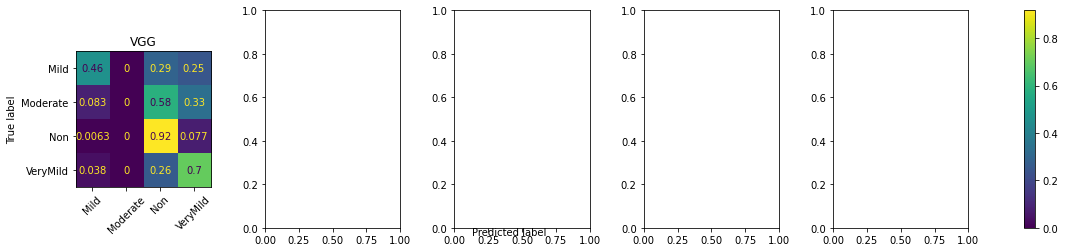

In [38]:
display_results([model_v_sgd])